Code for predicting the mask of new unseen image using the U-Net model, obtained from GitHub repository: "https://github.com/milesial/Pytorch-UNet" 
Identical to predict.py file but compatible with jupyter notebook

In [1]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset
from utils.augmentations import AugDataset

from dice_loss import dice_coeff

In [2]:
def predict_img(net, full_img, device, scale_factor=1, out_threshold=0.5):
    
    # set evaluation mode
    net.eval()
    
    # same preprocessing steps as for model training
    img = BasicDataset.preprocess(full_img, scale_factor)
    img = torch.from_numpy(AugDataset.preprocess(img))
    # return tensor of a dimension of size one
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)
    
    # disable gradient calculation
    with torch.no_grad():
        # predict mask
        output = net(img)
        # use softmax activation function for multiclass segmentation and sigmoid for binary
        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)
        
        # transform mask to PIL image, ensuring it has the same size intput image and store as tensor
        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()
    
    # convert to boolean
    return full_mask > out_threshold

In [3]:
# pass arguments
def get_args():
    parser = argparse.ArgumentParser(description='Predict masks from input images',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # pretrained model
    parser.add_argument('--model', '-m', default='MODEL.pth',
                        metavar='FILE',
                        help="Specify the file in which the model is stored")
    # directory of input image
    parser.add_argument('--input', '-i', metavar='INPUT', nargs='+',
                        help='filenames of input images', required=True)
    # directory of output image
    parser.add_argument('--output', '-o', metavar='INPUT', nargs='+',
                        help='Filenames of ouput images')
    # whether images will be visualised
    parser.add_argument('--viz', '-v', action='store_true',
                        help="Visualize the images as they are processed",
                        default=False)
    # whether output mask will be saved
    parser.add_argument('--no-save', '-n', action='store_true',
                        help="Do not save the output masks",
                        default=False)
    # probabilty value for considering mask pixel as white
    parser.add_argument('--mask-threshold', '-t', type=float,
                        help="Minimum probability value to consider a mask pixel white",
                        default=0.5)
    # input image scale
    parser.add_argument('--scale', '-s', type=float,
                        help="Scale factor for the input images",
                        default=0.5)

    return parser.parse_args()

In [4]:
# function for storing output maks
def get_output_filenames(args):
    in_files = args.input
    out_files = []

    if not args.output:
        for f in in_files:
            pathsplit = os.path.splitext(f)
            out_files.append("{}_OUT{}".format(pathsplit[0], pathsplit[1]))
    elif len(in_files) != len(args.output):
        logging.error("Input files and output files are not of the same length")
        raise SystemExit()
    else:
        out_files = args.output

    return out_files

# denormalise mask
def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))

In [5]:
def main(args):
    
    # get input directory of the image and output directory for the predicted mask
    in_files = args.input
    out_files = get_output_filenames(args)
    # initialise U-Net
    net = UNet(n_channels=3, n_classes=1)

    logging.info("Loading model {}".format(args.model))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')
    net.to(device=device)
    # load pretrained model's parameters
    net.load_state_dict(torch.load(args.model, map_location=device))

    logging.info("Model loaded !")

    for i, fn in enumerate(in_files):
        logging.info("\nPredicting image {} ...".format(fn))
        
        # get input image
        img = Image.open(fn)
        # predict mask
        mask = predict_img(net=net,
                           full_img=img,
                           scale_factor=args.scale,
                           out_threshold=args.mask_threshold,
                           device=device)
        # save predicted mask if indicated
        if not args.no_save:
            out_fn = out_files[i]
            result = mask_to_image(mask)
            result.save(out_files[i])

            logging.info("Mask saved to {}".format(out_files[i]))
            
        # visualise predicted mask if indicated
        if args.viz:
            logging.info("Visualizing results for image {}, close to continue ...".format(fn))
            plot_img_and_mask(img, mask)
    return

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


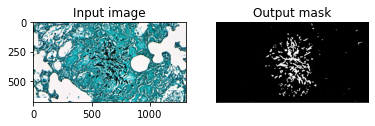

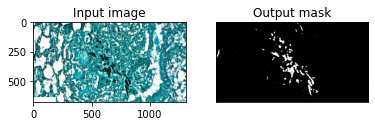

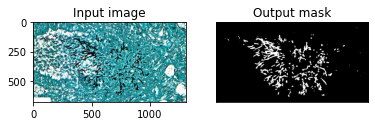

In [6]:
class empty: pass
args = empty()
args.model = './pretrained_model.pth'
args.input = [ './data/test/imgs/1M05_22.3x_11.jpg', './data/test/imgs/1M05_34.8x_10.jpg', './data/test/imgs/1M05_26.2x_12.jpg' ]
args.output = ['./data/test/out/1M05_22.3x_11.jpg', './data/test/out/1M05_34.8x_10.jpg', './data/test/out/1M05_26.2x_12.jpg']
args.scale = 1
args.mask_threshold = 0.5
args.no_save = False
args.viz = True
main(args)